In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
# from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from scipy import interp

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# reading in both csv files
df_users = pd.read_csv('user.csv')
df_job_desc = pd.read_csv('job_desc.csv')

In [3]:
# display for quick check
display(df_users.head())
display(df_job_desc.head())

,user_id,has_applied,v1,v10,v11,v12,v13,v14,v15,v16,...,v51,v52,v53,v54,v55,v56,v6,v7,v8,v9
0,U1,1,0.620573,0.018662,0.100803,0.080898,0.420417,0.817681,0.147355,0.446812,...,0.227104,0.811505,0.945988,0.798489,0.148969,0.707921,0.751510,0.349078,0.337132,0.807632
1,U2,1,0.972502,0.870277,0.504887,0.995163,0.179480,0.608719,0.245085,0.851246,...,0.855074,0.683701,0.318416,0.703566,0.400617,0.563469,0.989583,0.073514,0.095885,0.890821
2,U3,1,0.240756,0.546440,0.521399,0.402420,0.640444,NaN,0.184515,0.395058,...,0.614898,0.487564,0.256930,0.653874,0.761972,0.976820,0.264505,0.513135,0.978387,0.620669
3,U4,1,0.004854,0.433188,0.250801,0.242680,0.713586,0.210186,0.977472,0.375024,...,0.407412,0.242282,0.097724,0.191388,0.516972,0.742984,0.232344,0.305115,0.080069,0.297233
4,U5,1,0.835250,0.476812,0.764354,0.449753,0.524924,0.807181,0.294023,0.475043,...,0.605605,0.772735,0.351836,0.932708,0.724384,0.123647,0.091980,0.581444,0.093941,0.612623


,job_title_full,salary,company,user_id
0,Junior Manager Innovation Lab - France (M/F/D),51000.0,g,U1
1,Junior Product Manager - Mobile,70000.0,b,U2
2,Junior Brand Marketing Manager - Mobile (M/F/D),59000.0,g,U3
3,Product Analyst - Pricing & Forecasting (M/F/D),NaN,d,U4
4,Online Marketing Manager,64000.0,h,U5


In [4]:
# extracting basic knowledge about the dataset
if set(df_users['user_id'].unique()) == set(df_job_desc['user_id'].unique()):
    print('Two datasets have same set of unique users')
    if len(df_users) == len(df_job_desc):
        print('Two datasets have same size')
        if len(df_users) == len(df_users['user_id'].unique()):
            print('Both datasets rows are by unique users')
            
print('There are {} unique companies in total'.format(len(df_job_desc['company'].unique())))

# exploring positive label frequency
print('Frequency of Positive Label: {}'.format(df_users['has_applied'].sum()/len(df_users))) 

Two datasets have same set of unique users
Two datasets have same size
Both datasets rows are by unique users
There are 8 unique companies in total
Frequency of Positive Label: 0.576


In [5]:
# merging the two datasets
df_merged = pd.merge(df_users, df_job_desc.iloc[:,1:], on='user_id')
df_merged = df_merged.set_index('user_id')

# converting categorical variable 'Company' into numerical labels
df_merged['company_encoded'] = LabelEncoder().fit_transform(df_merged['company'])
df_merged = df_merged.drop('company', axis=1)
display(df_merged.head())

# Imputing missing values (NaN)
    # Median Imputation
print('Is there any missing value? {}'.format(df_merged.isnull().any().any()))
print('Imputing missing values...')
for col in df_merged.iloc[:,1:].columns:
    if df_merged[col].isnull().any():
        df_merged.loc[:,col] = df_merged[col].fillna(df_merged[col].median())
print('Is there any missing value now? {}'.format(df_merged.isnull().any().any()))

,has_applied,v1,v10,v11,v12,v13,v14,v15,v16,v17,...,v53,v54,v55,v56,v6,v7,v8,v9,salary,company_encoded
user_id,,,,,,,,,,,,,,,,,,,,,
U1,1,0.620573,0.018662,0.100803,0.080898,0.420417,0.817681,0.147355,0.446812,0.637663,...,0.945988,0.798489,0.148969,0.707921,0.751510,0.349078,0.337132,0.807632,51000.0,6
U2,1,0.972502,0.870277,0.504887,0.995163,0.179480,0.608719,0.245085,0.851246,0.354934,...,0.318416,0.703566,0.400617,0.563469,0.989583,0.073514,0.095885,0.890821,70000.0,1
U3,1,0.240756,0.546440,0.521399,0.402420,0.640444,NaN,0.184515,0.395058,0.856322,...,0.256930,0.653874,0.761972,0.976820,0.264505,0.513135,0.978387,0.620669,59000.0,6
U4,1,0.004854,0.433188,0.250801,0.242680,0.713586,0.210186,0.977472,0.375024,0.718613,...,0.097724,0.191388,0.516972,0.742984,0.232344,0.305115,0.080069,0.297233,NaN,3
U5,1,0.835250,0.476812,0.764354,0.449753,0.524924,0.807181,0.294023,0.475043,0.548697,...,0.351836,0.932708,0.724384,0.123647,0.091980,0.581444,0.093941,0.612623,64000.0,7


Is there any missing value? True
Imputing missing values...
Is there any missing value now? False


Top 10 predictive features: 
                     raw_coeff     abs_coeff  sign
salary           5.136191e-06  5.136191e-06   1.0
company_encoded  3.288672e-10  3.288672e-10   1.0
v3               5.764507e-11  5.764507e-11   1.0
v56              5.365655e-11  5.365655e-11   1.0
v27              5.206945e-11  5.206945e-11   1.0
v38              5.105467e-11  5.105467e-11   1.0
v24              5.078335e-11  5.078335e-11   1.0
v1               4.972425e-11  4.972425e-11   1.0
v43              4.969346e-11  4.969346e-11   1.0
v13              4.910724e-11  4.910724e-11   1.0 

---Fold 1

AUROC: 0.496054546847468

F1 Score: 0.5725

Classification Report ::
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       171
          1       0.57      1.00      0.73       229

avg / total       0.33      0.57      0.42       400

---Fold 2

AUROC: 0.5294010416666667

F1 Score: 0.6

Classification Report ::
             precision    recall  f1-score   

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


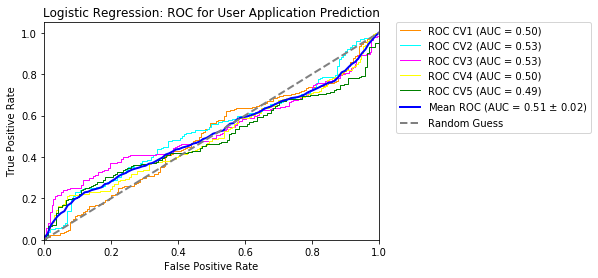

Mean F1 score across the folds: 0.576
The model took 0.9406249523162842 seconds


In [6]:
def LR(df):
    # specify target column
    target = 'has_applied'
    
    # define the model
    clf = LogisticRegression(random_state=0, solver='lbfgs')
    
    # fit the model to explore model coefficients (feature importance)
    df_x = df.drop(target, axis=1)
    df_y = df[target]
    clf.fit(df_x,df_y)

    # examine raw coefficients to obtain feature importance
    feature_importance = pd.Series(clf.coef_[0],index=df_x.columns).sort_values(ascending=False)
#     feature_importance = feature_importance[:10]
    feature_importance = feature_importance.to_frame()
    feature_importance = feature_importance.rename(columns={0: 'raw_coeff'})
    for idx, row in feature_importance.iterrows():
        feature_importance.loc[idx, 'abs_coeff'] = np.abs(row['raw_coeff'])
        feature_importance.loc[idx, 'sign'] = np.sign(row['raw_coeff'])
    feature_importance = feature_importance.sort_values(by='abs_coeff', ascending=False)
    print('Top 10 predictive features: \n',feature_importance[:10],'\n')
    
    # define kfold object before performing k-fold cross validation
    # I'm using 5-fold cross validation in this problem.
    fivefold = KFold(5,True,7) #input params: k, shuffle boolean, random seed
    

    fig = plt.figure()
    colors = ['darkorange', 'cyan', 'magenta', 'yellow', 'green']
    k_counter = 1
    mean_fpr = np.linspace(0,1,100)
    tprs = []
    aurocs = []
    f1s = []
    
    # for each fold, generating/plotting ROC curve and Classification Report
    for train_array, val_array in fivefold.split(df):
        print('---Fold '+str(k_counter)+'\n')
#         display(df.iloc[train])
#         display(df.iloc[test])
        train = df.iloc[train_array]
        val = df.iloc[val_array]
        train_x = train.drop(target,axis=1)
        train_y = train[target]
        val_x  = val.drop(target, axis=1)
        val_y  = val[target]
        
        clf_fit = clf.fit(train_x, train_y)
        
        probs = clf_fit.predict_proba(val_x)
        pos_probs = probs[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(val_y, pos_probs, pos_label=1)
        print('AUROC: {}\n'.format(roc_auc_score(val_y, pos_probs)))
        tprs.append(interp(mean_fpr, fpr, tpr))
        aurocs.append(roc_auc_score(val_y, pos_probs))
        
        preds = clf_fit.predict(val_x)
        f1 = f1_score(val_y, preds, average='micro')
        print('F1 Score: {}\n'.format(f1))
        f1s.append(f1)
        print('Classification Report ::\n'+metrics.classification_report(val_y, preds))
    
        plt.plot(fpr, tpr, color=colors[k_counter-1],
                 lw=1, label='ROC CV'+str(k_counter)+' (AUC = %0.2f)' % roc_auc_score(val_y, pos_probs))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

        k_counter += 1
    
    # generating/plotting mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_auroc = metrics.auc(mean_fpr, mean_tpr)
    std_auroc = np.std(aurocs)
    plt.plot(mean_fpr, mean_tpr, color='blue',
                 lw=2, label='Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auroc,std_auroc))
    # plotting the random guess line
    plt.plot([0, 1], [0, 1], color='grey', lw=2, label='Random Guess', linestyle='--')
    plt.legend(loc="lower right", bbox_to_anchor=(1.65, 0.47))
    plt.title('Logistic Regression: ROC for User Application Prediction')
    plt.savefig("AUROC_Logistic Regression_User_Application")
    plt.show()
    feature_importance.to_csv('LR_feature_importance.csv')
    print('Mean F1 score across the folds: {}'.format(np.asarray(f1s).mean()))

start_time = time.time()
LR(df_merged)
print('The model took {} seconds'.format(time.time()-start_time))


Top 10 predictive features: 
                  raw_coeff  abs_coeff  sign
company_encoded   0.010203   0.010203   1.0
v5                0.010203   0.010203   1.0
v37               0.010203   0.010203   1.0
v9                0.010203   0.010203   1.0
v8                0.010203   0.010203   1.0
v7                0.010203   0.010203   1.0
v6                0.010203   0.010203   1.0
v56               0.010203   0.010203   1.0
v55               0.010203   0.010203   1.0
v54               0.010203   0.010203   1.0 

---Fold 1

AUROC: 0.6809418013738858

F1 Score: 0.6475

Classification Report ::
             precision    recall  f1-score   support

          0       0.59      0.58      0.58       171
          1       0.69      0.70      0.69       229

avg / total       0.65      0.65      0.65       400

---Fold 2

AUROC: 0.7068229166666667

F1 Score: 0.68

Classification Report ::
             precision    recall  f1-score   support

          0       0.60      0.59      0.60       160
  

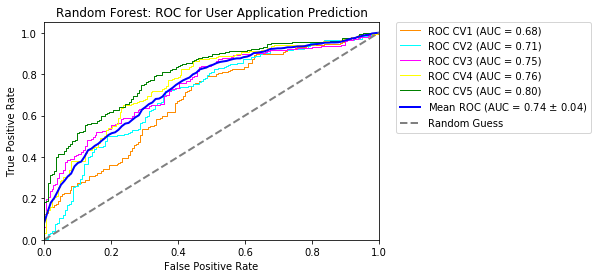

Mean F1 score across the folds: 0.6900000000000001
The model took 29.255517959594727 seconds


In [7]:
def RF(df):
    
    # specify target column
    target = 'has_applied'
    
    # define the model
    num_trees =200 #70 #90 #30
    clf = RandomForestClassifier(n_estimators=num_trees, min_samples_leaf=10, 
                                     max_features=25, max_depth=50, class_weight='balanced')#max_features="sqrt", min_samples_split=10, max_depth=20, min_samples_leaf=4)#max_depth=30, min_samples_leaf=2) # or just max_depth=20, min_samples_leaf=1
#     if len(df.columns) <10:
#         clf = RandomForestClassifier(n_estimators=num_trees, min_samples_leaf=5, 
#                                      max_features="sqrt", max_depth=20, class_weight='balanced')#max_features="sqrt", min_samples_split=10, max_depth=20, min_samples_leaf=4)#max_depth=30, min_samples_leaf=2) # or just max_depth=20, min_samples_leaf=1
#     else:
#         clf = RandomForestClassifier(n_estimators=num_trees, min_samples_leaf=5, 
#                                      max_features=20, max_depth=20, class_weight='balanced')
    
    # fit the model to explore model coefficients (feature importance)
    df_x = df.drop(target, axis=1)
    df_y = df[target]
    clf.fit(df_x,df_y)

    # examine raw coefficients to obtain feature importance
    feature_importance = pd.Series(clf.feature_importances_[0],index=df_x.columns).sort_values(ascending=False)
#     feature_importance = feature_importance[:10]
    feature_importance = feature_importance.to_frame()
    feature_importance = feature_importance.rename(columns={0: 'raw_coeff'})
    for idx, row in feature_importance.iterrows():
        feature_importance.loc[idx, 'abs_coeff'] = np.abs(row['raw_coeff'])
        feature_importance.loc[idx, 'sign'] = np.sign(row['raw_coeff'])
    feature_importance = feature_importance.sort_values(by='abs_coeff', ascending=False)
    print('Top 10 predictive features: \n',feature_importance[:10],'\n')
    
    # define kfold object before performing k-fold cross validation
    # I'm using 5-fold cross validation in this problem.
    fivefold = KFold(5,True,7) #input params: k, shuffle boolean, random seed
    

    fig = plt.figure()
    colors = ['darkorange', 'cyan', 'magenta', 'yellow', 'green']
    k_counter = 1
    mean_fpr = np.linspace(0,1,100)
    tprs = []
    aurocs = []
    f1s = []
    
    # for each fold, generating/plotting ROC curve and Classification Report
    for train_array, val_array in fivefold.split(df):
        print('---Fold '+str(k_counter)+'\n')
#         display(df.iloc[train])
#         display(df.iloc[test])
        train = df.iloc[train_array]
        val = df.iloc[val_array]
        train_x = train.drop(target,axis=1)
        train_y = train[target]
        val_x  = val.drop(target, axis=1)
        val_y  = val[target]
        
        clf_fit = clf.fit(train_x, train_y)
        
        probs = clf_fit.predict_proba(val_x)
        pos_probs = probs[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(val_y, pos_probs, pos_label=1)
        print('AUROC: {}\n'.format(roc_auc_score(val_y, pos_probs)))
        tprs.append(interp(mean_fpr, fpr, tpr))
        aurocs.append(roc_auc_score(val_y, pos_probs))
        
        preds = clf_fit.predict(val_x)
        f1 = f1_score(val_y, preds, average='micro')
        print('F1 Score: {}\n'.format(f1))
        f1s.append(f1)
        print('Classification Report ::\n'+metrics.classification_report(val_y, preds))
    
        plt.plot(fpr, tpr, color=colors[k_counter-1],
                 lw=1, label='ROC CV'+str(k_counter)+' (AUC = %0.2f)' % roc_auc_score(val_y, pos_probs))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

        k_counter += 1
    
    # generating/plotting mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_auroc = metrics.auc(mean_fpr, mean_tpr)
    std_auroc = np.std(aurocs)
    plt.plot(mean_fpr, mean_tpr, color='blue',
                 lw=2, label='Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auroc,std_auroc))
    # plotting the random guess line
    plt.plot([0, 1], [0, 1], color='grey', lw=2, label='Random Guess', linestyle='--')
    plt.legend(loc="lower right", bbox_to_anchor=(1.65, 0.47))
    plt.title('Random Forest: ROC for User Application Prediction')
    plt.savefig("AUROC_Random Forest_User_Application")
    plt.show()
    feature_importance.to_csv('RF_feature_importance.csv')
    print('Mean F1 score across the folds: {}'.format(np.asarray(f1s).mean()))
    
start_time = time.time()
RF(df_merged)
print('The model took {} seconds'.format(time.time()-start_time))


Top 10 predictive features: 
                  raw_coeff  abs_coeff  sign
company_encoded   0.015902   0.015902   1.0
v5                0.015902   0.015902   1.0
v37               0.015902   0.015902   1.0
v9                0.015902   0.015902   1.0
v8                0.015902   0.015902   1.0
v7                0.015902   0.015902   1.0
v6                0.015902   0.015902   1.0
v56               0.015902   0.015902   1.0
v55               0.015902   0.015902   1.0
v54               0.015902   0.015902   1.0 

---Fold 1

AUROC: 0.7216987154932456

F1 Score: 0.66

Classification Report ::
             precision    recall  f1-score   support

          0       0.63      0.51      0.56       171
          1       0.68      0.77      0.72       229

avg / total       0.66      0.66      0.65       400

---Fold 2

AUROC: 0.7084114583333333

F1 Score: 0.6625

Classification Report ::
             precision    recall  f1-score   support

          0       0.60      0.47      0.53       160
  

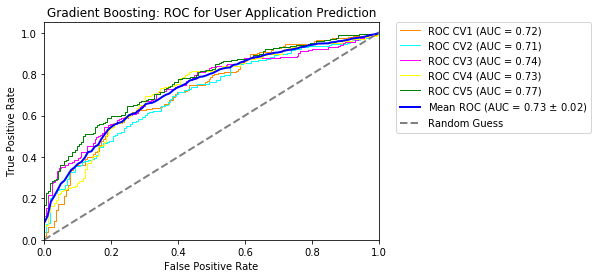

Mean F1 score across the folds: 0.6775
The model took 5.310918092727661 seconds


In [8]:
def GBoost(df):    
    # specify target column
    target = 'has_applied'
    
    # define the model
    clf = GradientBoostingClassifier(n_estimators=60, min_samples_leaf=10, 
                                     max_features="sqrt", max_depth=50)#max_features="sqrt", min_samples_split=10, max_depth=20, min_samples_leaf=4)#max_depth=30, min_samples_leaf=2) # or just max_depth=20, min_sample
#     if len(df.columns) <10:
#         clf = GradientBoostingClassifier(n_estimators=60, min_samples_leaf=5, 
#                                      max_features="sqrt", max_depth=20)#max_features="sqrt", min_samples_split=10, max_depth=20, min_samples_leaf=4)#max_depth=30, min_samples_leaf=2) # or just max_depth=20, min_samples_leaf=1
#     else:
#         clf = GradientBoostingClassifier(n_estimators=60, min_samples_leaf=5, 
#                                      max_features=20, max_depth=20)

    
    # fit the model to explore model coefficients (feature importance)
    df_x = df.drop(target, axis=1)
    df_y = df[target]
    clf.fit(df_x,df_y)

    # examine raw coefficients to obtain feature importance
    feature_importance = pd.Series(clf.feature_importances_[0],index=df_x.columns).sort_values(ascending=False)
#     feature_importance = feature_importance[:10]
    feature_importance = feature_importance.to_frame()
    feature_importance = feature_importance.rename(columns={0: 'raw_coeff'})
    for idx, row in feature_importance.iterrows():
        feature_importance.loc[idx, 'abs_coeff'] = np.abs(row['raw_coeff'])
        feature_importance.loc[idx, 'sign'] = np.sign(row['raw_coeff'])
    feature_importance = feature_importance.sort_values(by='abs_coeff', ascending=False)
    print('Top 10 predictive features: \n',feature_importance[:10],'\n')
    
    # define kfold object before performing k-fold cross validation
    # I'm using 5-fold cross validation in this problem.
    fivefold = KFold(5,True,7) #input params: k, shuffle boolean, random seed
    

    fig = plt.figure()
    colors = ['darkorange', 'cyan', 'magenta', 'yellow', 'green']
    k_counter = 1
    mean_fpr = np.linspace(0,1,100)
    tprs = []
    aurocs = []
    f1s = []
    
    # for each fold, generating/plotting ROC curve and Classification Report
    for train_array, val_array in fivefold.split(df):
        print('---Fold '+str(k_counter)+'\n')
#         display(df.iloc[train])
#         display(df.iloc[test])
        train = df.iloc[train_array]
        val = df.iloc[val_array]
        train_x = train.drop(target,axis=1)
        train_y = train[target]
        val_x  = val.drop(target, axis=1)
        val_y  = val[target]
        
        clf_fit = clf.fit(train_x, train_y)
        
        probs = clf_fit.predict_proba(val_x)
        pos_probs = probs[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(val_y, pos_probs, pos_label=1)
        print('AUROC: {}\n'.format(roc_auc_score(val_y, pos_probs)))
        tprs.append(interp(mean_fpr, fpr, tpr))
        aurocs.append(roc_auc_score(val_y, pos_probs))
        
        preds = clf_fit.predict(val_x)
        f1 = f1_score(val_y, preds, average='micro')
        print('F1 Score: {}\n'.format(f1))
        f1s.append(f1)
        print('Classification Report ::\n'+metrics.classification_report(val_y, preds))
    
        plt.plot(fpr, tpr, color=colors[k_counter-1],
                 lw=1, label='ROC CV'+str(k_counter)+' (AUC = %0.2f)' % roc_auc_score(val_y, pos_probs))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

        k_counter += 1
    
    # generating/plotting mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_auroc = metrics.auc(mean_fpr, mean_tpr)
    std_auroc = np.std(aurocs)
    plt.plot(mean_fpr, mean_tpr, color='blue',
                 lw=2, label='Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auroc,std_auroc))
    # plotting the random guess line
    plt.plot([0, 1], [0, 1], color='grey', lw=2, label='Random Guess', linestyle='--')
    plt.legend(loc="lower right", bbox_to_anchor=(1.65, 0.47))
    plt.title('Gradient Boosting: ROC for User Application Prediction')
    plt.savefig("AUROC_Gradient Boosting_User_Application")
    plt.show()
    feature_importance.to_csv('GB_feature_importance.csv')
    print('Mean F1 score across the folds: {}'.format(np.asarray(f1s).mean()))

start_time = time.time()
GBoost(df_merged)
print('The model took {} seconds'.format(time.time()-start_time))


Top 10 predictive features: 
                  raw_coeff  abs_coeff  sign
company_encoded -93.445983  93.445983  -1.0
v45             -22.756038  22.756038  -1.0
v5              -21.240102  21.240102  -1.0
v3               19.425054  19.425054   1.0
v27              18.286505  18.286505   1.0
v51             -17.505668  17.505668  -1.0
v37             -14.894874  14.894874  -1.0
v13              14.757381  14.757381   1.0
v55             -14.752735  14.752735  -1.0
v56              14.679017  14.679017   1.0 

---Fold 1

AUROC: 0.43170152455374244

F1 Score: 0.4275

Classification Report ::
             precision    recall  f1-score   support

          0       0.43      0.99      0.60       171
          1       0.50      0.00      0.01       229

avg / total       0.47      0.43      0.26       400

---Fold 2

AUROC: 0.49963541666666667

F1 Score: 0.4000000000000001

Classification Report ::
             precision    recall  f1-score   support

          0       0.40      1.00      0

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


AUROC: 0.49697919563184106

F1 Score: 0.4525

Classification Report ::
             precision    recall  f1-score   support

          0       0.45      0.99      0.62       179
          1       0.75      0.01      0.03       221

avg / total       0.62      0.45      0.29       400

---Fold 4

AUROC: 0.507753813246416

F1 Score: 0.4425

Classification Report ::
             precision    recall  f1-score   support

          0       0.44      0.99      0.61       173
          1       0.83      0.02      0.04       227

avg / total       0.66      0.44      0.29       400

---Fold 5

AUROC: 0.5041650548033526

F1 Score: 0.555

Classification Report ::
             precision    recall  f1-score   support

          0       0.39      0.13      0.20       165
          1       0.58      0.85      0.69       235

avg / total       0.50      0.56      0.49       400



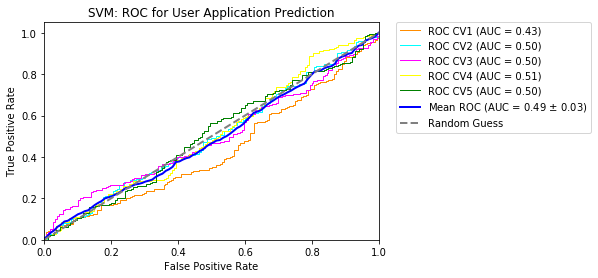

Mean F1 score across the folds: 0.45550000000000007
The model took 6898.81989979744 seconds


In [9]:
def SVM(df):
# specify target column
    target = 'has_applied'
    
    # define the model
    clf = SVC(kernel='linear',probability=True) # if want to measure feature importance
    
    # fit the model to explore model coefficients (feature importance)
    df_x = df.drop(target, axis=1)
    df_y = df[target]
    clf.fit(df_x,df_y)

    # examine raw coefficients to obtain feature importance
    feature_importance = pd.Series(clf.coef_[0],index=df_x.columns).sort_values(ascending=False)
#     feature_importance = feature_importance[:10]
    feature_importance = feature_importance.to_frame()
    feature_importance = feature_importance.rename(columns={0: 'raw_coeff'})
    for idx, row in feature_importance.iterrows():
        feature_importance.loc[idx, 'abs_coeff'] = np.abs(row['raw_coeff'])
        feature_importance.loc[idx, 'sign'] = np.sign(row['raw_coeff'])
    feature_importance = feature_importance.sort_values(by='abs_coeff', ascending=False)
    print('Top 10 predictive features: \n',feature_importance[:10],'\n')
    
    # define kfold object before performing k-fold cross validation
    # I'm using 5-fold cross validation in this problem.
    fivefold = KFold(5,True,7) #input params: k, shuffle boolean, random seed
    

    fig = plt.figure()
    colors = ['darkorange', 'cyan', 'magenta', 'yellow', 'green']
    k_counter = 1
    mean_fpr = np.linspace(0,1,100)
    tprs = []
    aurocs = []
    f1s = []
    
    # for each fold, generating/plotting ROC curve and Classification Report
    for train_array, val_array in fivefold.split(df):
        print('---Fold '+str(k_counter)+'\n')
#         display(df.iloc[train])
#         display(df.iloc[test])
        train = df.iloc[train_array]
        val = df.iloc[val_array]
        train_x = train.drop(target,axis=1)
        train_y = train[target]
        val_x  = val.drop(target, axis=1)
        val_y  = val[target]
        
        clf_fit = clf.fit(train_x, train_y)
        
        probs = clf_fit.predict_proba(val_x)
        pos_probs = probs[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(val_y, pos_probs, pos_label=1)
        print('AUROC: {}\n'.format(roc_auc_score(val_y, pos_probs)))
        tprs.append(interp(mean_fpr, fpr, tpr))
        aurocs.append(roc_auc_score(val_y, pos_probs))
        
        preds = clf_fit.predict(val_x)
        f1 = f1_score(val_y, preds, average='micro')
        print('F1 Score: {}\n'.format(f1))
        f1s.append(f1)
        print('Classification Report ::\n'+metrics.classification_report(val_y, preds))
    
        plt.plot(fpr, tpr, color=colors[k_counter-1],
                 lw=1, label='ROC CV'+str(k_counter)+' (AUC = %0.2f)' % roc_auc_score(val_y, pos_probs))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

        k_counter += 1
    
    # generating/plotting mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_auroc = metrics.auc(mean_fpr, mean_tpr)
    std_auroc = np.std(aurocs)
    plt.plot(mean_fpr, mean_tpr, color='blue',
                 lw=2, label='Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auroc,std_auroc))
    # plotting the random guess line
    plt.plot([0, 1], [0, 1], color='grey', lw=2, label='Random Guess', linestyle='--')
    plt.legend(loc="lower right", bbox_to_anchor=(1.65, 0.47))
    plt.title('SVM: ROC for User Application Prediction')
    plt.savefig("AUROC_SVM_User_Application")
    plt.show()
    feature_importance.to_csv('SVM_feature_importance.csv')
    print('Mean F1 score across the folds: {}'.format(np.asarray(f1s).mean()))

start_time = time.time()
SVM(df_merged)
print('The model took {} seconds'.format(time.time()-start_time))
